In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import random
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report

import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings('ignore')

In [21]:
df_train = pd.read_csv('train_format1.csv')
df_test = pd.read_csv('test_format1.csv')
df_log = pd.read_csv('user_log_format1.csv')
df_user = pd.read_csv('user_info_format1.csv')

In [22]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [23]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


In [25]:
df_log.rename(columns={'seller_id': 'merchant_id'}, inplace=True)
df_log['brand_id'] = df_log['brand_id'].fillna(-1).astype('int32')

df_user['age_range'] = df_user['age_range'].fillna(-1).astype('int8')
df_user['gender'] = df_user['gender'].fillna(2).astype('int8')

df_log['time_stamp'] = pd.to_datetime(df_log['time_stamp'],format='%m%d')
max_time = df_log['time_stamp'].max()
df_log['days_from_max'] = (max_time - df_log['time_stamp'])
df_log['days_from_max'] = df_log['days_from_max'].dt.days

In [26]:
df_log_dummies = pd.get_dummies(df_log['action_type'], prefix='action')
df_log = pd.concat([df_log, df_log_dummies], axis=1)
df_log.rename(columns={
    'action_0': 'act_click',
    'action_1': 'act_cart',
    'action_2': 'act_buy',
    'action_3': 'act_fav'
}, inplace=True)

In [27]:
u_feats = df_log.groupby('user_id').agg({
    'item_id': 'count',        # 用户总交互次数
    'merchant_id': 'nunique',  # 用户逛过多少家店
    'cat_id': 'nunique',       # 用户看过多少品类
    'brand_id': 'nunique',     # 用户看过多少品牌
    'act_click': 'sum',
    'act_cart': 'sum',
    'act_buy': 'sum',
    'act_fav': 'sum'
}).reset_index()

u_feats.columns = ['user_id', 'u_total_acts', 'u_n_merchants', 'u_n_cats', 'u_n_brands', 
                   'u_clicks', 'u_carts', 'u_buys', 'u_favs']

u_feats['u_buy_ratio'] = u_feats['u_buys'] / u_feats['u_total_acts']
u_feats = u_feats.merge(df_user, on='user_id', how='left')

In [28]:
m_feats = df_log.groupby('merchant_id').agg({
    'user_id': 'nunique',      # 商家有多少访客
    'item_id': 'nunique',      # 商家有多少商品被交互
    'cat_id': 'nunique',       # 商家覆盖品类数
    'brand_id': 'nunique',     # 商家覆盖品牌数
    'act_click': 'sum',
    'act_cart': 'sum',
    'act_buy': 'sum',
    'act_fav': 'sum'
}).reset_index()

m_feats.columns = ['merchant_id', 'm_n_users', 'm_n_items', 'm_n_cats', 'm_n_brands', 
                   'm_clicks', 'm_carts', 'm_buys', 'm_favs']

In [29]:
buy_logs = df_log[df_log['act_buy'] == 1]
merchant_user_buy_counts = buy_logs.groupby(['merchant_id', 'user_id']).size().reset_index(name='buy_count')
merchant_user_buy_counts['is_repeat'] = (merchant_user_buy_counts['buy_count'] >= 2).astype(int)
m_rep_stats = merchant_user_buy_counts.groupby('merchant_id').agg({
    'user_id': 'count',      # 购买用户总数
    'is_repeat': 'sum'       # 复购用户数
}).reset_index()
m_rep_stats['m_repurchase_rate'] = m_rep_stats['is_repeat'] / m_rep_stats['user_id']
m_feats = m_feats.merge(m_rep_stats[['merchant_id', 'm_repurchase_rate']], on='merchant_id', how='left')
m_feats['m_repurchase_rate'] = m_feats['m_repurchase_rate'].fillna(0)

In [30]:
um_feats = df_log.groupby(['user_id', 'merchant_id']).agg({
    'item_id': 'count',        # 交互总次数
    'act_click': 'sum',
    'act_cart': 'sum',
    'act_buy': 'sum',
    'act_fav': 'sum',
    'days_from_max': ['min', 'max', 'nunique'],
}).reset_index()

# 展平列名
um_feats.columns = ['user_id', 'merchant_id', 'um_total_acts', 'um_clicks', 'um_carts', 'um_buys', 'um_favs',
                     'um_days_from_max_min', 'um_days_from_max_max', 'um_interact_days',
                    ]

um_feats['um_buy_ratio'] = um_feats['um_buys'] / (um_feats['um_total_acts'] + 1e-6)
um_feats['um_recency'] = um_feats['um_days_from_max_min']  # 最近一次交互距离"现在"的天数
um_feats['um_buy_density'] = um_feats['um_buys'] / (um_feats['um_interact_days'] + 1)  # 购买密度

In [31]:

time_windows = [3, 7, 15]
max_days = df_log['days_from_max'].max()

um_time_feats_list = []

for window in time_windows:
    # 筛选最近window天的数据   
    recent_logs = df_log[df_log['days_from_max'] <= window].copy()
    
    if len(recent_logs) > 0:
        um_recent = recent_logs.groupby(['user_id', 'merchant_id']).agg({
            'item_id': 'count',
            'act_click': 'sum',
            'act_cart': 'sum',
            'act_buy': 'sum',
            'act_fav': 'sum'
        }).reset_index()
        
        um_recent.columns = ['user_id', 'merchant_id', 
                            f'um_recent_{window}d_acts', f'um_recent_{window}d_clicks',
                            f'um_recent_{window}d_carts', f'um_recent_{window}d_buys',
                            f'um_recent_{window}d_favs']
        
        um_recent[f'um_recent_{window}d_buy_ratio'] = um_recent[f'um_recent_{window}d_buys'] / (um_recent[f'um_recent_{window}d_acts'] + 1e-6)
        
        um_time_feats_list.append(um_recent)

if um_time_feats_list:
    um_time_feats = um_time_feats_list[0]
    for feat_df in um_time_feats_list[1:]:
        um_time_feats = um_time_feats.merge(feat_df, on=['user_id', 'merchant_id'], how='outer')
    
    # 合并到um_feats
    um_feats = um_feats.merge(um_time_feats, on=['user_id', 'merchant_id'], how='left')
    
    # 填充缺失值（没有最近N天行为的，填充为0）
    time_cols = [col for col in um_feats.columns if 'recent' in col]
    um_feats[time_cols] = um_feats[time_cols].fillna(0)


um_feats.head()


,user_id,merchant_id,um_total_acts,um_clicks,um_carts,um_buys,um_favs,um_days_from_max_min,um_days_from_max_max,um_interact_days,...,um_recent_7d_carts,um_recent_7d_buys,um_recent_7d_favs,um_recent_7d_buy_ratio,um_recent_15d_acts,um_recent_15d_clicks,um_recent_15d_carts,um_recent_15d_buys,um_recent_15d_favs,um_recent_15d_buy_ratio
0,1,471,1,1,0,0,0,1,1,1,...,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.000000
1,1,739,1,1,0,0,0,25,25,1,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,1,925,4,3,0,1,0,32,32,1,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,1,1019,14,10,0,4,0,1,1,1,...,0.0,4.0,0.0,0.285714,14.0,10.0,0.0,4.0,0.0,0.285714
4,1,1156,1,1,0,0,0,1,1,1,...,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.000000


In [32]:
# 1. 商家在用户所有行为中的占比（商家权重）
user_total_acts = df_log.groupby('user_id')['item_id'].count().reset_index(name='user_all_acts')
um_feats = um_feats.merge(user_total_acts, on='user_id', how='left')
um_feats['um_merchant_weight'] = um_feats['um_total_acts'] / (um_feats['user_all_acts'] + 1e-6)

# 2. 用户在该商家的购买次数占用户总购买次数的比例
user_total_buys = df_log[df_log['act_buy'] == 1].groupby('user_id')['item_id'].count().reset_index(name='user_all_buys')
um_feats = um_feats.merge(user_total_buys, on='user_id', how='left')
um_feats['um_merchant_buy_weight'] = um_feats['um_buys'] / (um_feats['user_all_buys'].fillna(0) + 1e-6)

# 3. 用户在该商家平均每天的行为次数
um_feats['um_acts_per_day'] = um_feats['um_total_acts'] / (um_feats['um_interact_days'] + 1)

# 4. 用户在该商家是否有"先收藏/加购再购买"的行为序列（简化版：同时有收藏/加购和购买）
um_feats['um_has_cart_before_buy'] = ((um_feats['um_carts'] > 0) & (um_feats['um_buys'] > 0)).astype(int)
um_feats['um_has_fav_before_buy'] = ((um_feats['um_favs'] > 0) & (um_feats['um_buys'] > 0)).astype(int)

# 删除临时列
um_feats = um_feats.drop(['user_all_acts', 'user_all_buys'], axis=1, errors='ignore')

print(f"用户-商家交互质量特征已添加，当前um_feats列数: {len(um_feats.columns)}")
um_feats.head()


用户-商家交互质量特征已添加，当前um_feats列数: 36


,user_id,merchant_id,um_total_acts,um_clicks,um_carts,um_buys,um_favs,um_days_from_max_min,um_days_from_max_max,um_interact_days,...,um_recent_15d_clicks,um_recent_15d_carts,um_recent_15d_buys,um_recent_15d_favs,um_recent_15d_buy_ratio,um_merchant_weight,um_merchant_buy_weight,um_acts_per_day,um_has_cart_before_buy,um_has_fav_before_buy
0,1,471,1,1,0,0,0,1,1,1,...,1.0,0.0,0.0,0.0,0.000000,0.030303,0.000000,0.5,0,0
1,1,739,1,1,0,0,0,25,25,1,...,0.0,0.0,0.0,0.0,0.000000,0.030303,0.000000,0.5,0,0
2,1,925,4,3,0,1,0,32,32,1,...,0.0,0.0,0.0,0.0,0.000000,0.121212,0.166667,2.0,0,0
3,1,1019,14,10,0,4,0,1,1,1,...,10.0,0.0,4.0,0.0,0.285714,0.424242,0.666667,7.0,0,0
4,1,1156,1,1,0,0,0,1,1,1,...,1.0,0.0,0.0,0.0,0.000000,0.030303,0.000000,0.5,0,0


In [33]:

u_feats_enhanced = df_log.groupby('user_id').agg({
    'merchant_id': 'nunique',  # 已存在，但再确认
    'item_id': 'nunique',      # 用户交互过的商品数
    'cat_id': 'nunique',       # 已存在
    'brand_id': 'nunique',     # 已存在
    'act_buy': 'sum',          # 已存在
    'act_fav': 'sum',          # 已存在
    'act_cart': 'sum',         # 已存在
    'days_from_max': 'min',    # 用户最近一次行为距离"现在"的天数
    'time_stamp': ['min', 'max']  # 用户最早和最近的行为时间
}).reset_index()

u_feats_enhanced.columns = ['user_id', 'u_n_merchants_check', 'u_n_items', 'u_n_cats_check', 
                             'u_n_brands_check', 'u_buys_check', 'u_favs_check', 'u_carts_check',
                             'u_recency', 'u_time_min', 'u_time_max']

# 用户活跃天数
user_active_days = df_log.groupby(['user_id', 'days_from_max']).size().reset_index(name='count')
user_active_days = user_active_days.groupby('user_id').size().reset_index(name='u_active_days')
u_feats_enhanced = u_feats_enhanced.merge(user_active_days, on='user_id', how='left')
u_feats_enhanced['u_active_days'] = u_feats_enhanced['u_active_days'].fillna(0)

# 商家侧补充特征
m_feats_enhanced = df_log.groupby('merchant_id').agg({
    'user_id': 'nunique',      # 已存在
    'item_id': 'nunique',      # 已存在
    'act_cart': 'sum',         # 已存在
    'act_fav': 'sum',          # 已存在
    'act_buy': 'sum',          # 已存在
}).reset_index()

m_feats_enhanced.columns = ['merchant_id', 'm_n_users_check', 'm_n_items_check',
                           'm_carts_check', 'm_favs_check', 'm_buys_check']

# 商家被加购/收藏/购买的用户比例
m_feats_enhanced['m_cart_user_ratio'] = m_feats_enhanced['m_carts_check'] / (m_feats_enhanced['m_n_users_check'] + 1e-6)
m_feats_enhanced['m_fav_user_ratio'] = m_feats_enhanced['m_favs_check'] / (m_feats_enhanced['m_n_users_check'] + 1e-6)
m_feats_enhanced['m_buy_user_ratio'] = m_feats_enhanced['m_buys_check'] / (m_feats_enhanced['m_n_users_check'] + 1e-6)

# 商家被多次购买的用户比例（复购率，已在m_feats中，这里补充一个简化版）
buy_logs = df_log[df_log['act_buy'] == 1]
merchant_user_buy_counts = buy_logs.groupby(['merchant_id', 'user_id']).size().reset_index(name='buy_count')
repeat_buyers = merchant_user_buy_counts[merchant_user_buy_counts['buy_count'] >= 2].groupby('merchant_id')['user_id'].count().reset_index(name='m_repeat_buyers')
m_feats_enhanced = m_feats_enhanced.merge(repeat_buyers, on='merchant_id', how='left')
m_feats_enhanced['m_repeat_buyer_ratio'] = m_feats_enhanced['m_repeat_buyers'].fillna(0) / (m_feats_enhanced['m_n_users_check'] + 1e-6)

# 合并到原有特征
u_feats = u_feats.merge(u_feats_enhanced[['user_id', 'u_n_items', 'u_recency', 'u_active_days']], 
                        on='user_id', how='left')
m_feats = m_feats.merge(m_feats_enhanced[['merchant_id', 'm_cart_user_ratio', 'm_fav_user_ratio', 
                                           'm_buy_user_ratio', 'm_repeat_buyer_ratio']], 
                        on='merchant_id', how='left')


In [34]:
df_train = df_train.merge(um_feats, on=['user_id', 'merchant_id'], how='left')
df_train = df_train.merge(u_feats, on='user_id', how='left')
df_train = df_train.merge(m_feats, on='merchant_id', how='left')
fill_zero_cols = [
    'um_total_acts', 'um_clicks', 'um_carts', 'um_buys', 'um_favs',
    'u_total_acts', 'u_clicks', 'u_carts', 'u_buys', 'u_favs',
    'm_clicks', 'm_carts', 'm_buys', 'm_favs'
]

cols_to_fill = [col for col in fill_zero_cols if col in df_train.columns]
df_train[cols_to_fill] = df_train[cols_to_fill].fillna(0)

# 填充其他新增特征的缺失值
new_feat_cols = [col for col in df_train.columns if col not in ['user_id', 'merchant_id', 'label'] 
                 and df_train[col].isnull().any()]
if new_feat_cols:
    df_train[new_feat_cols] = df_train[new_feat_cols].fillna(0)

# 1. 用户购买率 × 商家复购率
if 'u_buy_ratio' in df_train.columns and 'm_repurchase_rate' in df_train.columns:
    df_train['cross_u_buy_ratio_m_repurchase'] = df_train['u_buy_ratio'] * df_train['m_repurchase_rate']

# 2. 用户-商家购买率 × 用户整体购买率
if 'um_buy_ratio' in df_train.columns and 'u_buy_ratio' in df_train.columns:
    df_train['cross_um_buy_u_buy'] = df_train['um_buy_ratio'] * df_train['u_buy_ratio']

# 3. 用户-商家交互次数 × 商家访客数（交互强度）
if 'um_total_acts' in df_train.columns and 'm_n_users' in df_train.columns:
    df_train['cross_um_acts_m_users'] = df_train['um_total_acts'] * df_train['m_n_users']

# 4. 用户活跃天数 × 商家复购率
if 'u_active_days' in df_train.columns and 'm_repurchase_rate' in df_train.columns:
    df_train['cross_u_active_m_repurchase'] = df_train['u_active_days'] * df_train['m_repurchase_rate']

df_train.head()

,user_id,merchant_id,label,um_total_acts,um_clicks,um_carts,um_buys,um_favs,um_days_from_max_min,um_days_from_max_max,...,m_favs,m_repurchase_rate,m_cart_user_ratio,m_fav_user_ratio,m_buy_user_ratio,m_repeat_buyer_ratio,cross_u_buy_ratio_m_repurchase,cross_um_buy_u_buy,cross_um_acts_m_users,cross_u_active_m_repurchase
0,34176,3906,0,39,36,0,1,2,1,23,...,961,0.212903,0.004812,0.165149,0.070459,0.011342,0.016050,0.001933,226941,10.006452
1,34176,121,0,14,13,0,1,0,1,4,...,2699,0.363471,0.011069,0.246912,0.437288,0.091574,0.027401,0.005385,153034,17.083152
2,34176,4356,1,18,12,0,6,0,1,2,...,196,0.251852,0.007014,0.085927,0.422183,0.074529,0.018987,0.025129,41058,11.837037
3,34176,2217,0,2,1,0,1,0,1,1,...,4150,0.095382,0.005987,0.245999,0.220569,0.018731,0.007191,0.037694,33740,4.482946
4,230784,4818,0,8,7,0,1,0,1,4,...,1959,0.345640,0.017200,0.261200,0.364400,0.072400,0.044805,0.016204,60000,5.530236


In [35]:
if 'seller_id' in df_test.columns:
    df_test.rename(columns={'seller_id': 'merchant_id'}, inplace=True)

df_test = df_test.merge(um_feats, on=['user_id', 'merchant_id'], how='left')
df_test = df_test.merge(u_feats, on='user_id', how='left')
df_test = df_test.merge(m_feats, on='merchant_id', how='left')
fill_zero_cols = [
    'um_total_acts', 'um_clicks', 'um_carts', 'um_buys', 'um_favs',
    'u_total_acts', 'u_clicks', 'u_carts', 'u_buys', 'u_favs',
    'm_clicks', 'm_carts', 'm_buys', 'm_favs',
    'm_repurchase_rate'
]

cols_to_fill = [col for col in fill_zero_cols if col in df_test.columns]
df_test[cols_to_fill] = df_test[cols_to_fill].fillna(0)

# 填充其他新增特征的缺失值
new_feat_cols = [col for col in df_test.columns if col not in ['user_id', 'merchant_id'] 
                 and df_test[col].isnull().any()]
if new_feat_cols:
    df_test[new_feat_cols] = df_test[new_feat_cols].fillna(0)

# 添加交叉特征（与训练集保持一致）
if 'u_buy_ratio' in df_test.columns and 'm_repurchase_rate' in df_test.columns:
    df_test['cross_u_buy_ratio_m_repurchase'] = df_test['u_buy_ratio'] * df_test['m_repurchase_rate']

if 'um_buy_ratio' in df_test.columns and 'u_buy_ratio' in df_test.columns:
    df_test['cross_um_buy_u_buy'] = df_test['um_buy_ratio'] * df_test['u_buy_ratio']

if 'um_total_acts' in df_test.columns and 'm_n_users' in df_test.columns:
    df_test['cross_um_acts_m_users'] = df_test['um_total_acts'] * df_test['m_n_users']

if 'u_active_days' in df_test.columns and 'm_repurchase_rate' in df_test.columns:
    df_test['cross_u_active_m_repurchase'] = df_test['u_active_days'] * df_test['m_repurchase_rate']

if 'age_range' in df_test.columns and 'gender' in df_test.columns:
    df_test['cross_age_gender'] = df_test['age_range'].astype(str) + '_' + df_test['gender'].astype(str)

# 确保测试集特征与训练集一致
train_cols = [c for c in df_train.columns if c != 'label']
test_cols = df_test.columns.tolist()

# 如果测试集缺少某些特征，填充0
missing_cols = set(train_cols) - set(test_cols)
if missing_cols:
    for col in missing_cols:
        df_test[col] = 0

# 如果测试集有多余的特征，移除
df_test = df_test[train_cols]

df_test.head()

,user_id,merchant_id,um_total_acts,um_clicks,um_carts,um_buys,um_favs,um_days_from_max_min,um_days_from_max_max,um_interact_days,...,m_favs,m_repurchase_rate,m_cart_user_ratio,m_fav_user_ratio,m_buy_user_ratio,m_repeat_buyer_ratio,cross_u_buy_ratio_m_repurchase,cross_um_buy_u_buy,cross_um_acts_m_users,cross_u_active_m_repurchase
0,163968,4605,2,1,0,1,0,1,1,1,...,3439,0.284048,0.003973,0.220378,0.441910,0.081128,0.056108,0.098765,31210,7.385237
1,360576,1581,10,5,0,5,0,1,1,1,...,212,0.570533,0.004785,0.253589,1.081340,0.217703,0.044457,0.038961,8360,12.551724
2,98688,1964,6,5,0,1,0,1,1,1,...,771,0.296323,0.005742,0.158121,0.446473,0.084290,0.026457,0.014881,29256,2.963230
3,98688,3645,11,10,0,1,0,1,1,1,...,1365,0.173516,0.003536,0.155715,0.126283,0.017340,0.015492,0.008117,96426,1.735160
4,295296,3361,50,47,0,1,2,1,11,5,...,217,0.118557,0.005055,0.099724,0.107077,0.010570,0.004715,0.000795,108800,3.912371


In [36]:
y = df_train['label']
X = df_train.drop(['user_id','merchant_id','label'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state = 42)

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208691 entries, 13722 to 121958
Data columns (total 65 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   um_total_acts                   208691 non-null  int64  
 1   um_clicks                       208691 non-null  int64  
 2   um_carts                        208691 non-null  int64  
 3   um_buys                         208691 non-null  int64  
 4   um_favs                         208691 non-null  int64  
 5   um_days_from_max_min            208691 non-null  int64  
 6   um_days_from_max_max            208691 non-null  int64  
 7   um_interact_days                208691 non-null  int64  
 8   um_buy_ratio                    208691 non-null  float64
 9   um_recency                      208691 non-null  int64  
 10  um_buy_density                  208691 non-null  float64
 11  um_recent_3d_acts               208691 non-null  float64
 12  um_recent_3d_clic

In [38]:
model_lgb = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    verbose=-1)
model_lgb.fit(X_train, y_train)


LGBMClassifier(learning_rate=0.05, n_estimators=1000, random_state=42,
               verbose=-1)

In [39]:
def train_lgb_kfold(df_train, df_test, features, target_col='label', k=5):
    
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    oof_preds = np.zeros(df_train.shape[0])
    
    sub_preds = np.zeros(df_test.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_jobs': -1
    }

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[features], df_train[target_col])):
        print(f"Starting Fold {n_fold + 1} / {k}...")
        
        train_x, train_y = df_train[features].iloc[train_idx], df_train[target_col].iloc[train_idx]
        valid_x, valid_y = df_train[features].iloc[valid_idx], df_train[target_col].iloc[valid_idx]
        
        lgb_train = lgb.Dataset(train_x, label=train_y)
        lgb_valid = lgb.Dataset(valid_x, label=valid_y)
        
        clf = lgb.train(
            params,
            lgb_train,
            num_boost_round=10000,
            valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=100)
            ]
        )
        
        # 预测验证集 (Out-Of-Fold)
        oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration)
        
        # 预测测试集 (累加，最后取平均)
        sub_preds += clf.predict(df_test[features], num_iteration=clf.best_iteration) / k
        
        # 记录特征重要性
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print(f"Fold {n_fold + 1} AUC: {roc_auc_score(valid_y, oof_preds[valid_idx]):.5f}")

    # 打印整体 CV 分数
    cv_score = roc_auc_score(df_train[target_col], oof_preds)
    print(f"Full AUC score: {cv_score:.5f}")
    
    return sub_preds, feature_importance_df


In [40]:

lgb_features = [c for c in df_train.columns if c not in ['user_id', 'merchant_id', 'label']]

# 使用 LightGBM 做 K 折交叉验证，并在测试集上预测
lgb_test_preds, lgb_feat_importance = train_lgb_kfold(
    df_train=df_train,
    df_test=df_test,
    features=lgb_features,
    target_col='label',
    k=5,
)



Starting Fold 1 / 5...
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.723594	valid_1's auc: 0.677732
[200]	training's auc: 0.763029	valid_1's auc: 0.681826
[300]	training's auc: 0.794318	valid_1's auc: 0.68116
Early stopping, best iteration is:
[228]	training's auc: 0.772612	valid_1's auc: 0.682095
Fold 1 AUC: 0.68209
Starting Fold 2 / 5...
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.724689	valid_1's auc: 0.678287
[200]	training's auc: 0.765039	valid_1's auc: 0.681612
[300]	training's auc: 0.797377	valid_1's auc: 0.68323
[400]	training's auc: 0.822454	valid_1's auc: 0.683728
Early stopping, best iteration is:
[369]	training's auc: 0.815094	valid_1's auc: 0.683795
Fold 2 AUC: 0.68380
Starting Fold 3 / 5...
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.72564	valid_1's auc: 0.674178
[200]	training's auc: 0.766616	valid_1's auc: 0.678291
[300]	training's auc: 0.792907	va

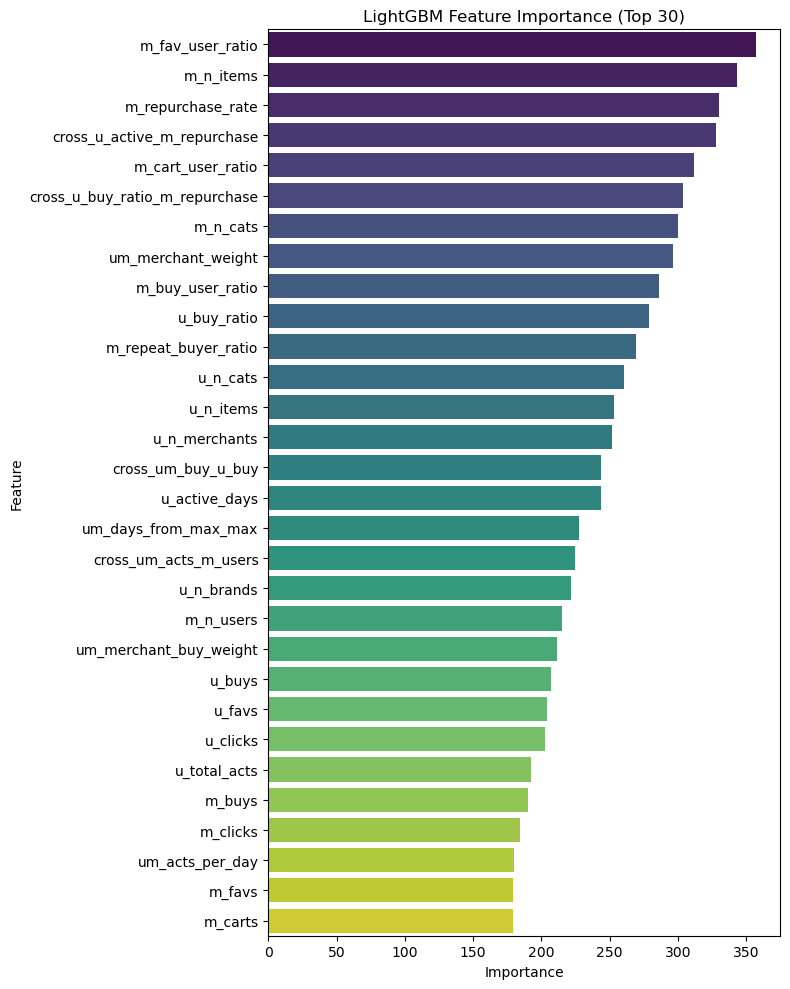

In [41]:
feat_imp = (
    lgb_feat_importance
    .groupby('feature', as_index=False)['importance']
    .mean()
    .sort_values('importance', ascending=False)
)

feat_imp.head()

top_n = 30
top_feat_imp = feat_imp.head(top_n)

plt.figure(figsize=(8, 10))
sns.barplot(
    data=top_feat_imp,
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title(f'LightGBM Feature Importance (Top {top_n})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [42]:
# 基于 LightGBM CV 的测试集预测结果，生成提交文件
submission_lgb = df_test[['user_id', 'merchant_id']].copy()
submission_lgb['prob'] = lgb_test_preds

submission_lgb.to_csv('lgb_cv_submission.csv', index=False)
submission_lgb.head()


,user_id,merchant_id,prob
0,163968,4605,0.057593
1,360576,1581,0.083003
2,98688,1964,0.053469
3,98688,3645,0.042779
4,295296,3361,0.071845
